# Load candidates

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:

CACHE = '/home/anhphantq/vdb/cache_train_test'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']
max_session = metadata['max_session']

for i in tqdm(range(num_frags)):
    with open(CACHE + f'/test_train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 1222/1222 [00:08<00:00, 149.94it/s]


In [3]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((5158157, 52), (5158157,))

In [4]:
from xgb_utils import create_test_data

In [5]:
train_data.shape

(5158157, 52)

In [6]:
import pandas as pd 

candidates = create_test_data(train_data, infer = False, max_session=max_session)


In [7]:
del train_data

In [8]:
import pandas as pd
pd.set_option('display.max_columns', candidates.shape[1])

In [9]:
candidates  


,user,item,fitness,inter_clicks,inter_carts,inter_orders,inter_num_sub,inter_time_decay,inter_lts,inter_fts,inter_durability,inter_num_interacts,num_sub,consistency,num_actions,user_pr,user_recent_pr,user_degree,num_clicks,num_carts,num_orders,item_pr,item_recent_pr,item_degree,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2,item_glob_last_action,item_glob_first_action,item_glob_time_decay_sum,item_glob_time_decay_sum_click,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_order,item_glob_item_glob_durability
0,11728125.0,1027512.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.560546e-08,2.934594e-08,1.0,78.0,0.0,0.0,3.770179e-07,3.718991e-07,59.0,6.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,20.855995,0.368437,31.245151,31.125793,0.119358,0.000000,20.487558
1,11453801.0,1569637.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.388289e-08,2.335854e-08,1.0,1038.0,216.0,136.0,3.133049e-06,2.908848e-06,718.0,40.0,8.0,4.0,51.0,9.0,4.0,63.0,6.0,4.0,68.0,10.0,7.0,23.0,9.0,5.0,43.0,10.0,5.0,58.0,11.0,11.0,20.944630,0.007280,582.383714,437.886343,87.037019,57.460352,20.937350
2,12401812.0,1053301.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.348915e-08,2.237236e-08,1.0,792.0,89.0,40.0,2.589840e-06,3.628019e-06,664.0,45.0,4.0,1.0,58.0,9.0,5.0,57.0,5.0,3.0,55.0,7.0,2.0,55.0,5.0,3.0,88.0,10.0,5.0,60.0,5.0,3.0,20.986111,0.553125,487.991350,420.618982,45.617693,21.754675,20.432986
3,11970743.0,196431.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.982426e-08,9.984735e-08,1.0,3.0,0.0,0.0,3.406027e-08,9.984735e-08,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.893623,6.299352,0.463843,0.463843,0.000000,0.000000,1.594271
4,12424410.0,1073953.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.156970,2.0,1.863376e-08,3.426599e-08,2.0,3092.0,167.0,52.0,1.001030e-05,8.275611e-06,1875.0,193.0,3.0,1.0,163.0,6.0,2.0,117.0,1.0,0.0,139.0,5.0,1.0,112.0,4.0,1.0,104.0,5.0,0.0,132.0,12.0,4.0,20.979618,0.003924,1340.134888,1257.617408,64.443233,18.074247,20.975694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12019656.0,364101.0,4.670696,1.0,0.0,0.0,1.0,0.934139,0.901709,0.901709,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,5021.0,1073.0,467.0,1.538493e-05,2.087291e-05,3411.0,209.0,57.0,19.0,210.0,57.0,20.0,301.0,44.0,25.0,280.0,54.0,24.0,333.0,91.0,31.0,347.0,101.0,50.0,495.0,132.0,61.0,20.992998,0.000058,3127.639949,2319.284331,562.301228,246.054390,20.992940
5158153,12019656.0,166821.0,4.112104,1.0,0.0,0.0,1.0,0.822421,0.717949,0.717949,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,249.0,51.0,13.0,7.114417e-07,1.463411e-06,184.0,23.0,9.0,2.0,15.0,1.0,0.0,46.0,10.0,3.0,27.0,3.0,1.0,30.0,6.0,0.0,41.0,9.0,2.0,61.0,7.0,4.0,20.996354,2.546273,239.406730,194.295937,35.326110,9.784684,18.450081
5158154,12019656.0,1609228.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.000000,0.000000,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,12529.0,2082.0,763.0,4.258929e-05,5.460850e-05,8339.0,985.0,154.0,68.0,717.0,125.0,45.0,723.0,123.0,41.0,609.0,123.0,46.0,1056.0,131.0,53.0,800.0,110.0,37.0,951.0,159.0,68.0,20.999769,0.017303,7584.671071,6208.296680,998.505520,377.868870,20.982465
5158155,12684187.0,637827.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.496760e-08,2.577288e-08,1.0,10863.0,1194

In [10]:
len(candidates.columns)

52

# Train params

In [11]:
PARAMS = {
    'max_depth' : 6,
    'eta': 0.5,    
    'min_child_weight': 1000,
    'tree_method': 'hist',
}
N_SPLITS = 3
NUM_TREE = 1000
MODEL_PATH = '/home/anhphantq/xgboost_test'
VERSION = '7'

# Train for each type

In [12]:
from xgb_utils import get_len_group

In [13]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [14]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
2212687,12899774,0,1399483,1
2212688,12899775,0,1760714,1
2212689,12899776,0,1737908,1
2212690,12899777,0,384045,1


In [15]:
candidates

,user,item,fitness,inter_clicks,inter_carts,inter_orders,inter_num_sub,inter_time_decay,inter_lts,inter_fts,inter_durability,inter_num_interacts,num_sub,consistency,num_actions,user_pr,user_recent_pr,user_degree,num_clicks,num_carts,num_orders,item_pr,item_recent_pr,item_degree,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day1_type0,recent_day1_type1,recent_day1_type2,item_glob_last_action,item_glob_first_action,item_glob_time_decay_sum,item_glob_time_decay_sum_click,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_order,item_glob_item_glob_durability
0,11728125.0,1027512.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.560546e-08,2.934594e-08,1.0,78.0,0.0,0.0,3.770179e-07,3.718991e-07,59.0,6.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,20.855995,0.368437,31.245151,31.125793,0.119358,0.000000,20.487558
1,11453801.0,1569637.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.388289e-08,2.335854e-08,1.0,1038.0,216.0,136.0,3.133049e-06,2.908848e-06,718.0,40.0,8.0,4.0,51.0,9.0,4.0,63.0,6.0,4.0,68.0,10.0,7.0,23.0,9.0,5.0,43.0,10.0,5.0,58.0,11.0,11.0,20.944630,0.007280,582.383714,437.886343,87.037019,57.460352,20.937350
2,12401812.0,1053301.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.348915e-08,2.237236e-08,1.0,792.0,89.0,40.0,2.589840e-06,3.628019e-06,664.0,45.0,4.0,1.0,58.0,9.0,5.0,57.0,5.0,3.0,55.0,7.0,2.0,55.0,5.0,3.0,88.0,10.0,5.0,60.0,5.0,3.0,20.986111,0.553125,487.991350,420.618982,45.617693,21.754675,20.432986
3,11970743.0,196431.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.982426e-08,9.984735e-08,1.0,3.0,0.0,0.0,3.406027e-08,9.984735e-08,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.893623,6.299352,0.463843,0.463843,0.000000,0.000000,1.594271
4,12424410.0,1073953.0,5.000000,1.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.156970,2.0,1.863376e-08,3.426599e-08,2.0,3092.0,167.0,52.0,1.001030e-05,8.275611e-06,1875.0,193.0,3.0,1.0,163.0,6.0,2.0,117.0,1.0,0.0,139.0,5.0,1.0,112.0,4.0,1.0,104.0,5.0,0.0,132.0,12.0,4.0,20.979618,0.003924,1340.134888,1257.617408,64.443233,18.074247,20.975694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158152,12019656.0,364101.0,4.670696,1.0,0.0,0.0,1.0,0.934139,0.901709,0.901709,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,5021.0,1073.0,467.0,1.538493e-05,2.087291e-05,3411.0,209.0,57.0,19.0,210.0,57.0,20.0,301.0,44.0,25.0,280.0,54.0,24.0,333.0,91.0,31.0,347.0,101.0,50.0,495.0,132.0,61.0,20.992998,0.000058,3127.639949,2319.284331,562.301228,246.054390,20.992940
5158153,12019656.0,166821.0,4.112104,1.0,0.0,0.0,1.0,0.822421,0.717949,0.717949,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,249.0,51.0,13.0,7.114417e-07,1.463411e-06,184.0,23.0,9.0,2.0,15.0,1.0,0.0,46.0,10.0,3.0,27.0,3.0,1.0,30.0,6.0,0.0,41.0,9.0,2.0,61.0,7.0,4.0,20.996354,2.546273,239.406730,194.295937,35.326110,9.784684,18.450081
5158154,12019656.0,1609228.0,2.500000,1.0,0.0,0.0,1.0,0.500000,0.000000,0.000000,0.0,1.0,0.0,0.154809,4.0,2.485327e-08,4.801381e-08,4.0,12529.0,2082.0,763.0,4.258929e-05,5.460850e-05,8339.0,985.0,154.0,68.0,717.0,125.0,45.0,723.0,123.0,41.0,609.0,123.0,46.0,1056.0,131.0,53.0,800.0,110.0,37.0,951.0,159.0,68.0,20.999769,0.017303,7584.671071,6208.296680,998.505520,377.868870,20.982465
5158155,12684187.0,637827.0,5.000000,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.000000,1.0,1.496760e-08,2.577288e-08,1.0,10863.0,1194

In [16]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import shutil
import matplotlib.pyplot as plt
def train(tar_, candidates_, t, num_cands, id_type):
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  candidates = candidates_.copy()
  candidates['type'] = id_type
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)

  # neg_idx = np.argwhere(candidates['label'].values.flatten() == 0)
  # neg_idx = np.random.permutation(neg_idx)[: int(len(neg_idx) * 0.5)]
  # candidates = candidates.drop(neg_idx.flatten()).reset_index()
  # num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
  # num_cands['num_cands'] = num_cands['item']
  # del num_cands['item'] 
  # candidates = candidates.merge(num_cands,on=['user'],how='left')
  # num_cands = candidates['num_cands'].values


  print(np.sum(candidates['label']), candidates.shape[0])
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,3, figsize = (30, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count(),
      **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          verbose_eval=5,
          early_stopping_rounds= 10, )
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 30)

remove old version
540517 5158157
[0]	train-map:0.95453	valid-map:0.95453
[5]	train-map:0.95600	valid-map:0.95591
[10]	train-map:0.95660	valid-map:0.95649
[15]	train-map:0.95690	valid-map:0.95666
[20]	train-map:0.95708	valid-map:0.95675
[25]	train-map:0.95719	valid-map:0.95682
[30]	train-map:0.95723	valid-map:0.95683
[35]	train-map:0.95747	valid-map:0.95697
[40]	train-map:0.95762	valid-map:0.95697
[45]	train-map:0.95769	valid-map:0.95705
[50]	train-map:0.95773	valid-map:0.95707
[55]	train-map:0.95778	valid-map:0.95706
[57]	train-map:0.95781	valid-map:0.95709
[0]	train-map:0.95457	valid-map:0.95460
[5]	train-map:0.95593	valid-map:0.95607
[10]	train-map:0.95650	valid-map:0.95657
[15]	train-map:0.95685	valid-map:0.95674
[20]	train-map:0.95695	valid-map:0.95684
[25]	train-map:0.95703	valid-map:0.95693
[30]	train-map:0.95713	valid-map:0.95692
[35]	train-map:0.95735	valid-map:0.95696
[40]	train-map:0.95750	valid-map:0.95706
[45]	train-map:0.95763	valid-map:0.95711
[50]	train-map:0.95768	vali

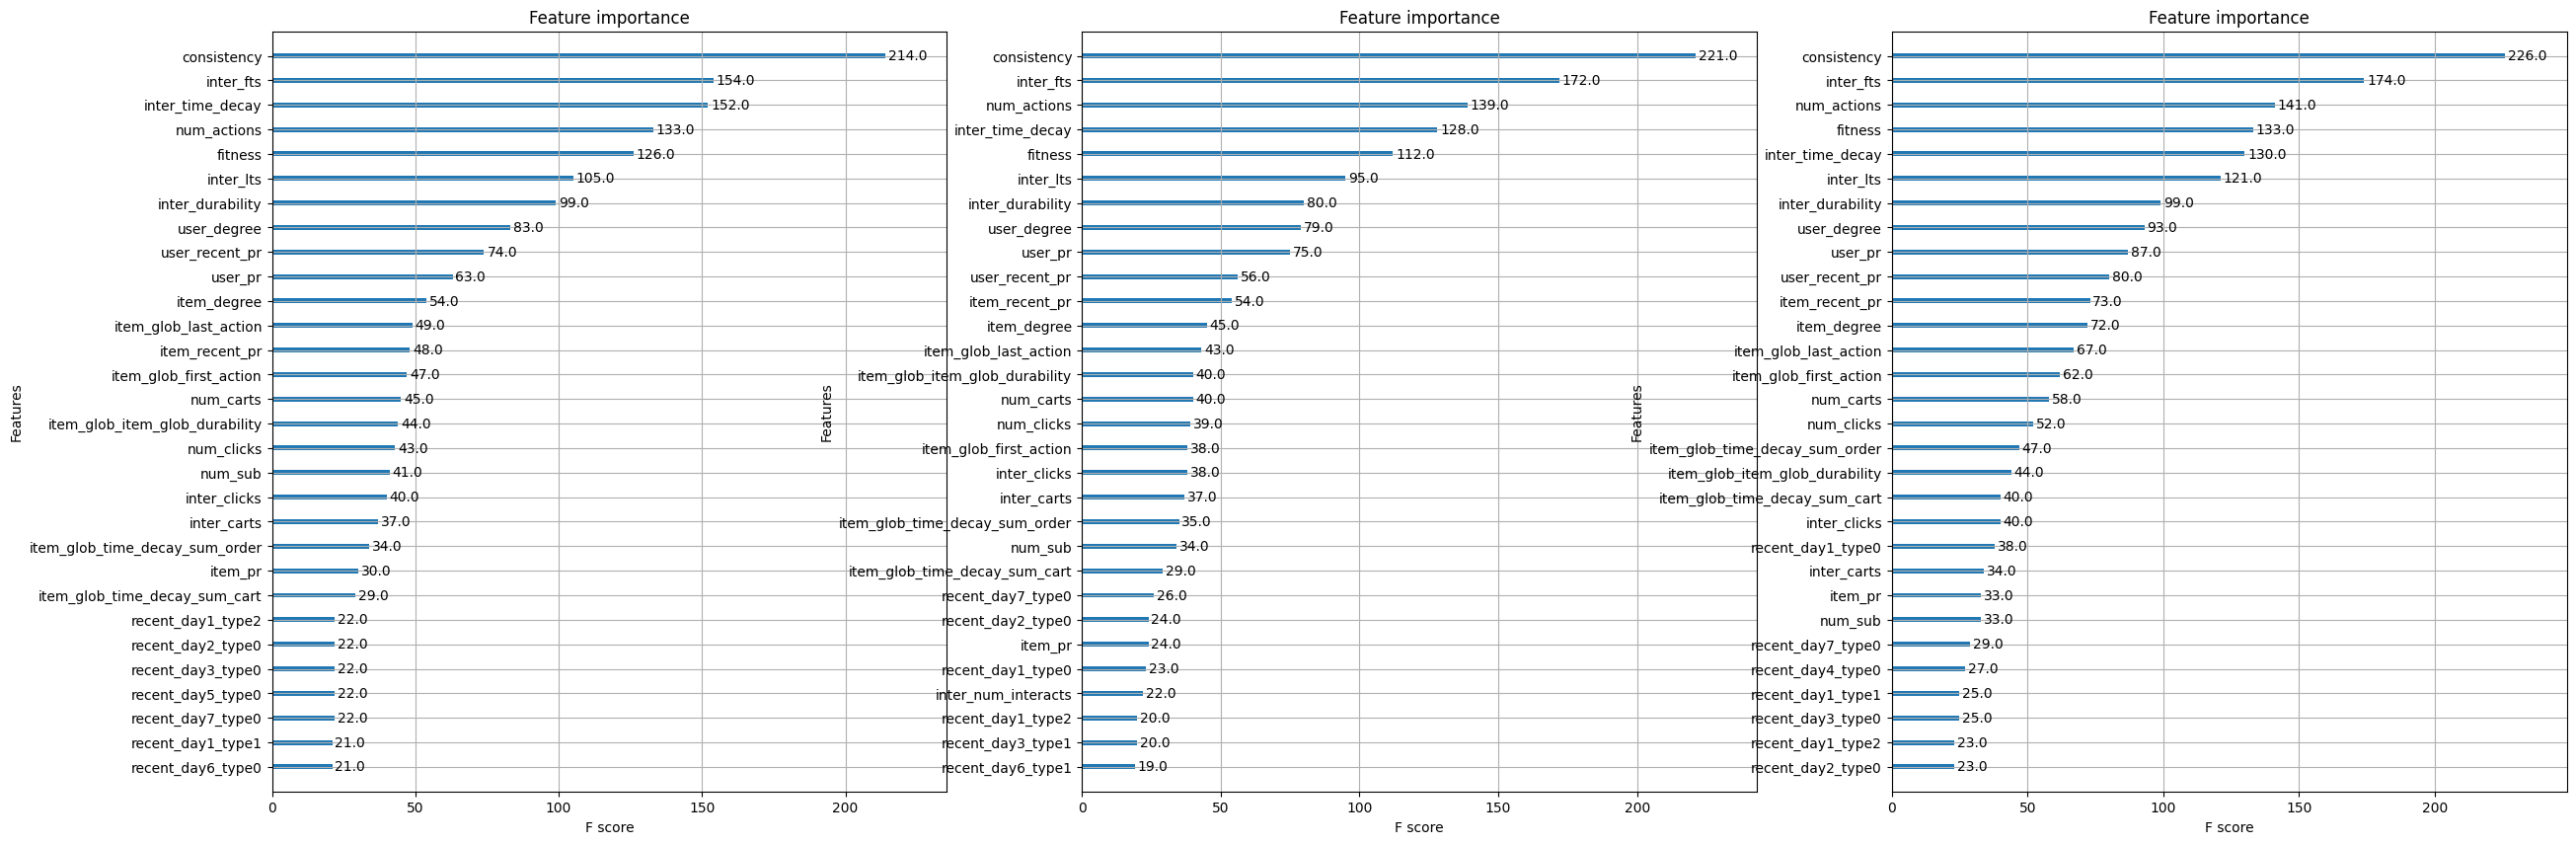

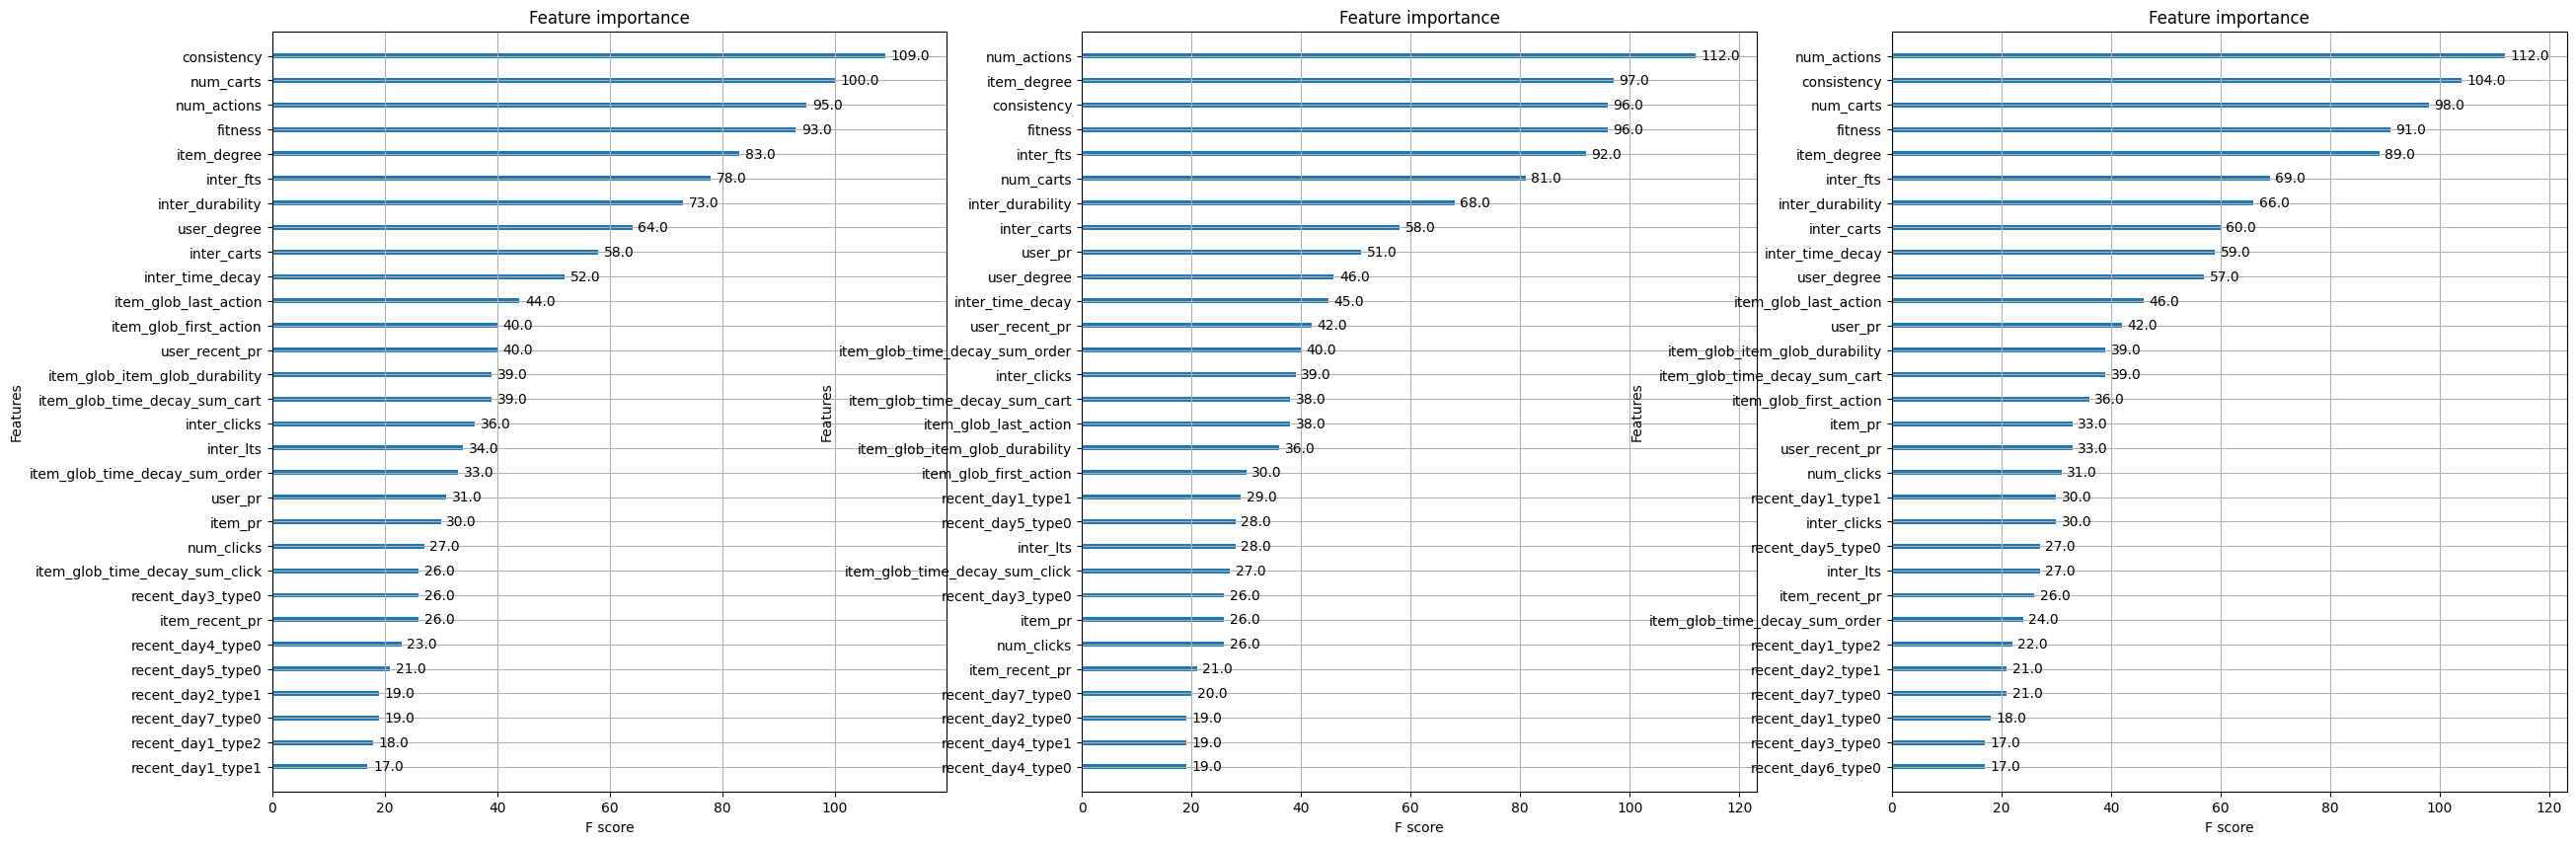

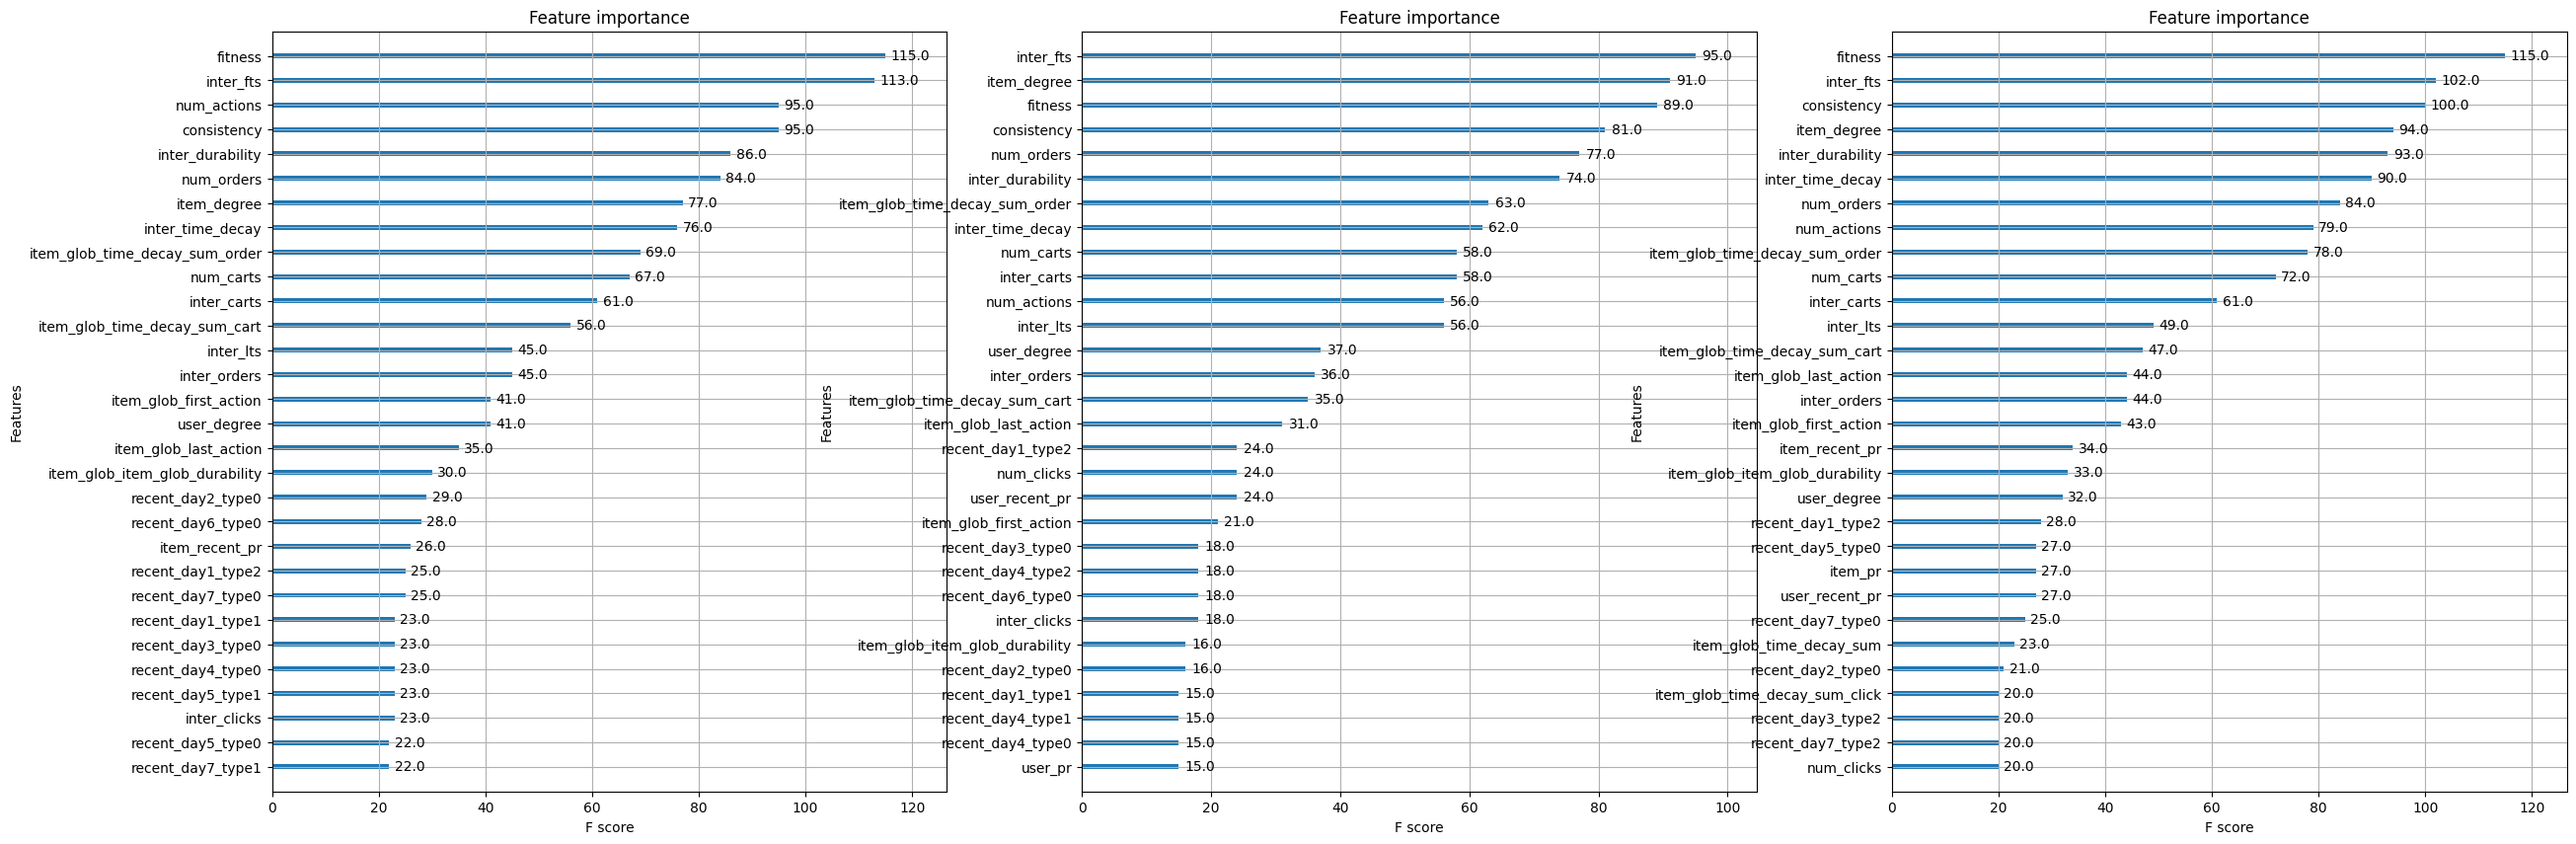

In [17]:
%%time
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, t, num_cands, id_type)